# Mean vibrational polarizabilities visualization

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from mybigdft import Logfile

conn = sqlite3.connect("../results.db")
c = conn.cursor()

In [2]:
# Set parameters for matplotlib
plt.rcParams.update({'font.size': 14})
colors = ['#d73027', '#f46d43', '#aaaaaa', '#66bd63', '#1a9850']

## Define some global variables

These variables store all the relevant data to be used in the following.

In [3]:
# Get all the relevant data
MOLECULES = [name for (name,) in c.execute("""SELECT name FROM molecule""").fetchall()]
HGRIDS = [value for (value,) in c.execute("""SELECT value FROM hgrid""").fetchall()][::-1]
RMULTS = c.execute("""SELECT frmult, crmult FROM rmult""").fetchall()
nb_notebooks = c.execute("SELECT COUNT(*) FROM notebook").fetchall()[0][0]
xmax = nb_notebooks // len(MOLECULES)

In [4]:
# Be sure to run the post_processing.ipynb notebook to make sure the
# converged_param table is in the database.
data = c.execute("""SELECT * FROM converged_param""").fetchall()
CONVERGED_PARAMS = {
    name: {"hgrids": hg, "rmult": [frm, crm]}
    for (name, hg, frm, crm) in data
}
# Looking at the convergence data, one suspects that the correct
# values for hgrids should be 0.38 for the CH4 molecule
CONVERGED_PARAMS["CH4"]["hgrids"] = 0.38

## Mean vibrational polarizability convergence for each molecule

In each plot below, which focuses on one particular molecule, each mean vibrational polarizability is represented by one point. A given column accounts for the mean vibrational polarizability found for one particular set of input parameters. The five first columns represent the mean vibrational polarizabilities for the highest hgrid, sorted by increasing rmult from left to right. It goes on like this by packet of five columns until the last five columns, which represent the mean vibrational polarizabilities for the lowest hgrid. The rightmost column represents the most converged mean vibrational polarizability: it corresponds to the computation with the smallest grid-step (hgrid) and the largest grid extension (rmult).

In [5]:
try:
    # Put all the relevant BigDFT data in a single temprary table
    c.execute("CREATE TEMP TABLE mean_vib_pols AS "
              "SELECT n.id, n.hgrid, mep.value, n.molecule, n.crmult, n.frmult "
              "FROM mean_vib_polarizability mep "
              "JOIN notebook n ON n.id = mep.id_notebook ")
except sqlite3.OperationalError as e:
    print(repr(e))

In [6]:
def plot_mean_vib_pols(name, only_converged=False):
    """
    Plot the mean vibrational polarizability of a given molecule.
    You can specifically filter the mean vibrational polarizability
    by svibting those coming from converged calculations
    ("converged" in the sense that the input parameters used to
    get these optimized positions were such that the precision per
    atom on the total energy of the system is below the desired value
    of 1 meV). The default is to use all the values, whether they can
    be considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the mean vibrational polarizabilities
        coming from converged calculations are plotted.
    """
    # Set the plot
    plt.figure(figsize=(6,4.5))
    # Set the value of the converged parameters
    if only_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
        suffix = " (only converged)"
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
        suffix = ""
    # Loop over the RMULTS to gather the mean vibrational polarizabilities
    for i, (frm, crm) in enumerate(RMULTS):
        if frm >= frm_min and crm >= crm_min:
            if "F" in name:
                # Filter out the larger hgrids
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM mean_vib_pols "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ?"
                    "      AND hgrid <= 0.35 ",
                    (name, crm, frm, hg_max)
                )
            else:
                c.execute(
                    "SELECT id, hgrid, value "
                    "FROM mean_vib_pols "
                    "WHERE molecule = ? AND crmult = ? AND frmult = ? "
                    "      AND hgrid <= ?",
                    (name, crm, frm, hg_max)
                )
        results = c.fetchall()
        x = [(id_nb - 1) // len(MOLECULES) for (id_nb, _, _) in results]
        mean_vib_pols = [mep for (_, _, mep) in results]
        label = f"Grid extension = [{frm}, {crm}]"
        plt.scatter(x, mean_vib_pols, label=label, c=colors[i%len(RMULTS)])
    # Plot vertical lines
    locs = [x * len(RMULTS) + len(RMULTS) - 0.5 for x in range(len(HGRIDS)-1)]
    ylim = plt.ylim()
    plt.vlines(locs, *ylim, linewidth=1)
    # Set x RMULTS
    locs = [x * len(RMULTS) + len(RMULTS) / 2 -0.5 for x in range(len(HGRIDS))]
    labels = [hg for hg in HGRIDS]
    plt.xticks(locs, labels)
    # Finalize plot
    plt.xlabel("Grid step")
    plt.ylabel(r"Mean vibrational polarizabilities [$\AA^3$]")
    plt.xlim(-1, xmax)
    plt.title(name+suffix)
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
def mean_vib_pols_stats(
        name, only_converged=False, only_not_converged=False,
        verbosity=True
    ):
    """
    Find the mean value and the standard deviation of the mean
    vibrational polarizability for a given molecule. You must
    specifically filter the mean vibrational polarizabilities
    coming from converged or not converged geometries ("converged"
    in the sense that the input parameters used to get these
    optimized positions were such that the precision per atom on the
    total energy of the system is below the desired value of 1 meV).
    The default is to use all the values, whether they can be
    considered as converged or not.
    
    Parameters
    ----------
    name : str
        Name of the molecule.
    only_converged : bool
        If `True`, then only the mean vibrational polarizabilities
        coming from converged calculations are used to define the
        stats.
    only_not_converged : bool
        If `True`, then only the mean vibrational polarizabilities
        coming from non-converged calculations are used to define
        the stats.
    """
    # Set the value of the converged parameters
    if only_converged or only_not_converged:
        hg_max = CONVERGED_PARAMS[name]["hgrids"]
        frm_min = CONVERGED_PARAMS[name]["rmult"][0]
        crm_min = CONVERGED_PARAMS[name]["rmult"][1]
    else:
        hg_max = max(HGRIDS)
        frm_min = min([frm for frm, _ in RMULTS])
        crm_min = min([crm for _, crm in RMULTS])
    # Gather the mean vibrational polarizabilities
    mean_vib_pols = []
    if only_not_converged:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM mean_vib_pols "
                "WHERE molecule = ? "  # mean vibrational polarizabilities from the desired molecule
                "      AND hgrid <= 0.35 "  # hgrid not too large when F atom(s) in the molecule
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",  # mean vibrational polarizabilities coming from non-converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM mean_vib_pols "
                "WHERE molecule = ? "
                "      AND (hgrid > ? OR frmult < ? OR crmult < ?)",
                (name, hg_max, frm_min, crm_min)
            )
    else:
        if "F" in name:
            # Filter out the larger hgrids
            c.execute(
                "SELECT value "
                "FROM mean_vib_pols "
                "WHERE molecule = ? "
                "      AND hgrid <= 0.35 "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",  # mean vibrational polarizabilities coming from all or converged notebooks
                (name, hg_max, frm_min, crm_min)
            )
        else:
            c.execute(
                "SELECT value "
                "FROM mean_vib_pols "
                "WHERE molecule = ? "
                "      AND hgrid <= ? AND frmult >= ? AND crmult >= ?",
                (name, hg_max, frm_min, crm_min)
            )
    mean_vib_pols += [mep for (mep,) in c.fetchall()]
    try:
        mean = np.mean(mean_vib_pols)
        std_dev = np.std(mean_vib_pols)
        results = f"mean = {mean:1.7f} A^3; std. dev. = {std_dev:.2e} A^3; std. dev / mean = {std_dev / mean:.3e}"
        if verbosity:
            print(name, results)
    except (FloatingPointError, RuntimeWarning):
        mean = None
        std_dev = None
        if verbosity:
            print("Cannot compute quanitites")
    return mean, std_dev

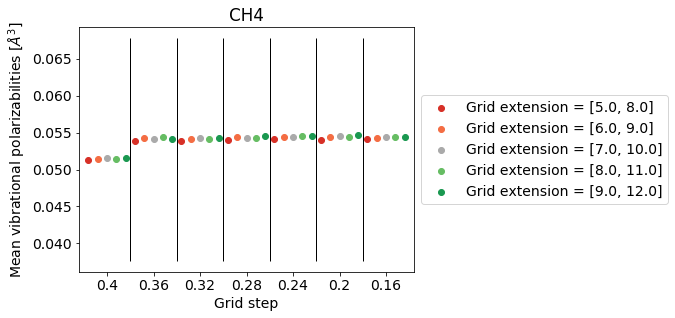

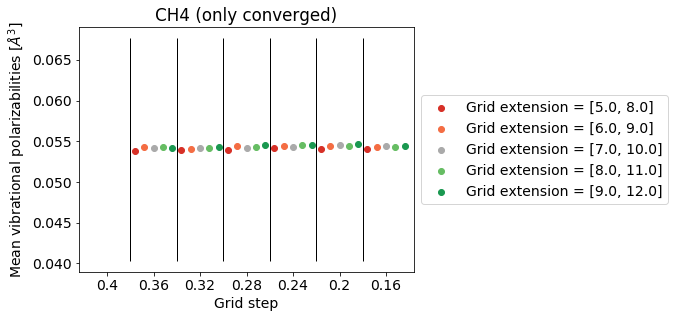

CH4 mean = 0.0542887 A^3; std. dev. = 2.02e-04 A^3; std. dev / mean = 3.730e-03
CH4 mean = 0.0514685 A^3; std. dev. = 1.14e-04 A^3; std. dev / mean = 2.207e-03


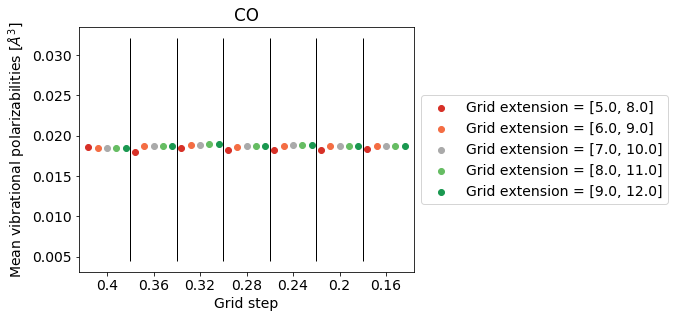

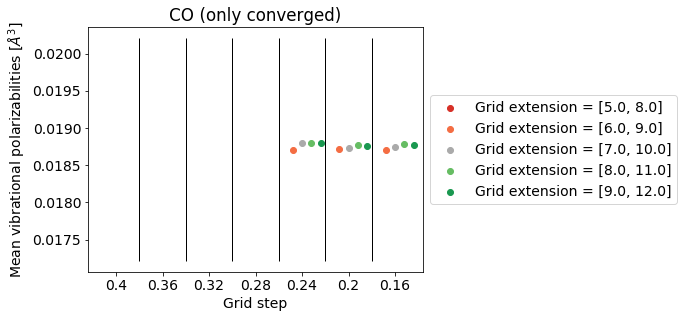

CO mean = 0.0187570 A^3; std. dev. = 3.32e-05 A^3; std. dev / mean = 1.770e-03
CO mean = 0.0185919 A^3; std. dev. = 2.42e-04 A^3; std. dev / mean = 1.304e-02


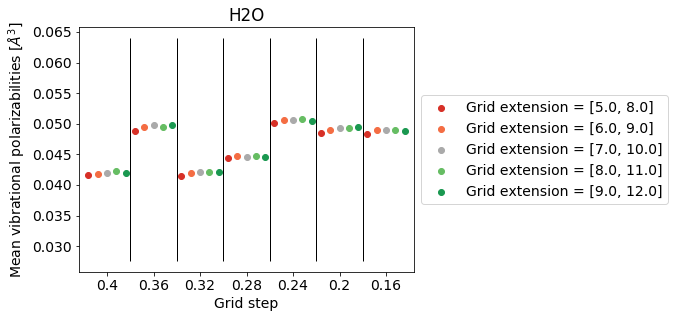

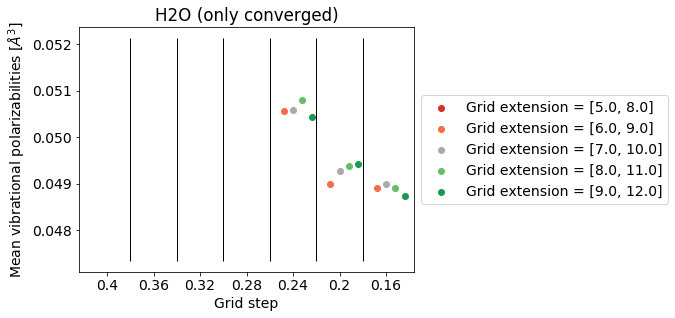

H2O mean = 0.0495808 A^3; std. dev. = 7.49e-04 A^3; std. dev / mean = 1.510e-02
H2O mean = 0.0450643 A^3; std. dev. = 3.25e-03 A^3; std. dev / mean = 7.218e-02


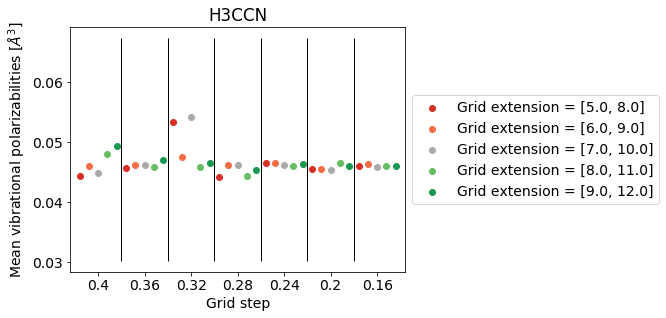

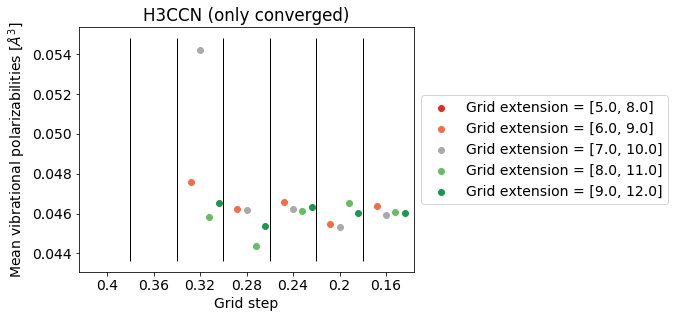

H3CCN mean = 0.0464718 A^3; std. dev. = 1.88e-03 A^3; std. dev / mean = 4.051e-02
H3CCN mean = 0.0466659 A^3; std. dev. = 2.20e-03 A^3; std. dev / mean = 4.707e-02


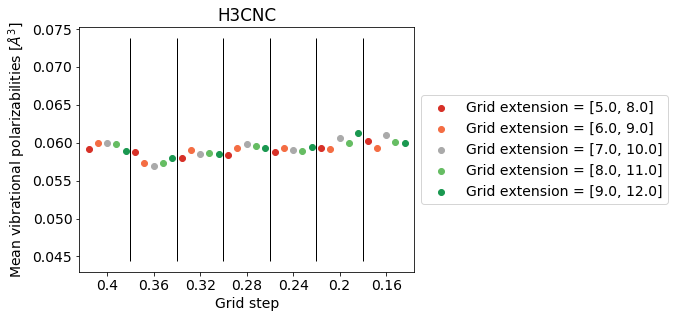

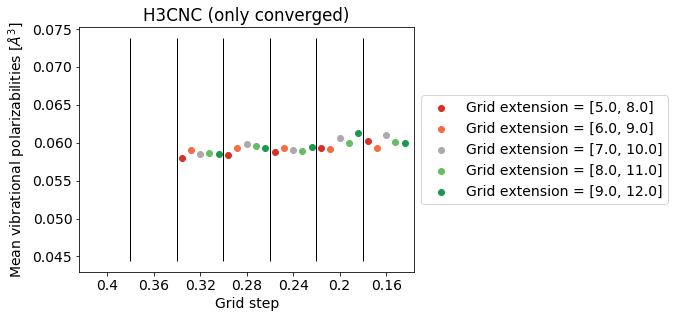

H3CNC mean = 0.0594178 A^3; std. dev. = 7.85e-04 A^3; std. dev / mean = 1.322e-02
H3CNC mean = 0.0586201 A^3; std. dev. = 1.10e-03 A^3; std. dev / mean = 1.876e-02


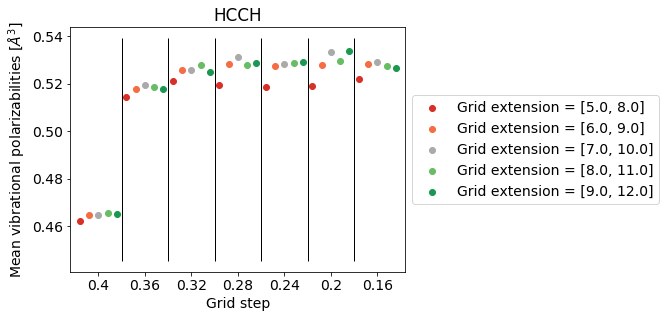

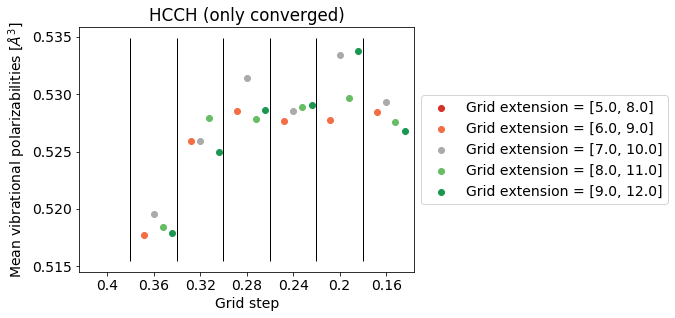

HCCH mean = 0.5268988 A^3; std. dev. = 4.29e-03 A^3; std. dev / mean = 8.151e-03
HCCH mean = 0.4943038 A^3; std. dev. = 2.73e-02 A^3; std. dev / mean = 5.518e-02


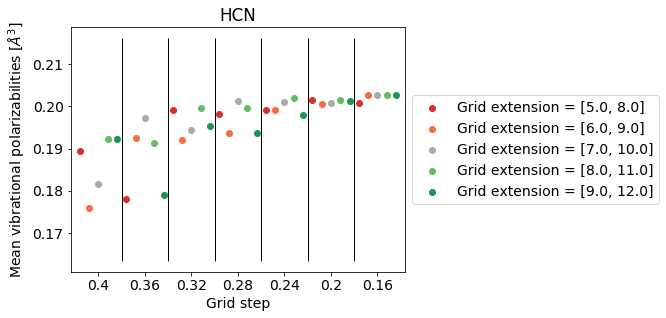

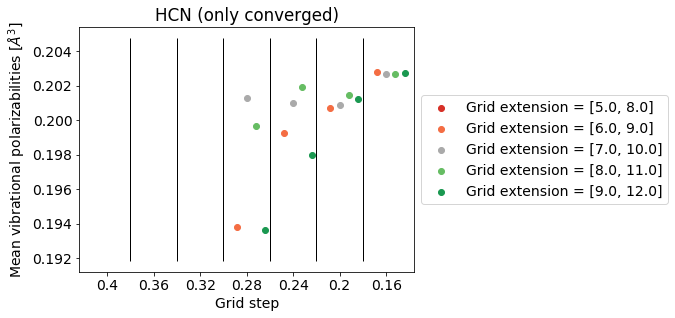

HCN mean = 0.2002364 A^3; std. dev. = 2.79e-03 A^3; std. dev / mean = 1.391e-02
HCN mean = 0.1921345 A^3; std. dev. = 7.75e-03 A^3; std. dev / mean = 4.032e-02


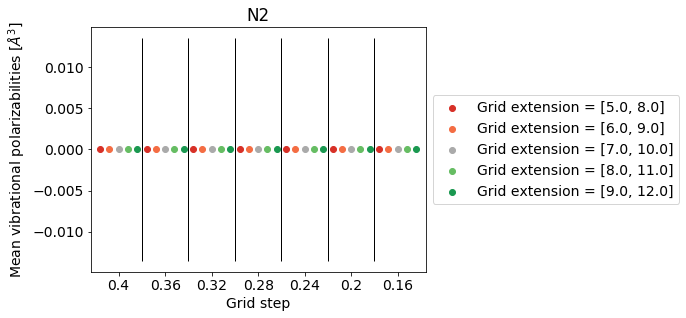

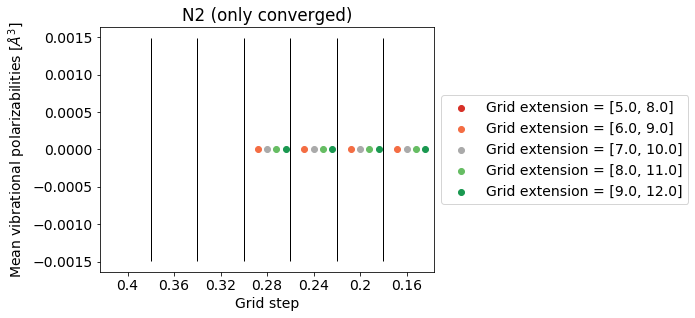

N2 mean = 0.0000000 A^3; std. dev. = 3.33e-08 A^3; std. dev / mean = 1.156e+00
N2 mean = 0.0000000 A^3; std. dev. = 1.26e-08 A^3; std. dev / mean = 9.911e-01


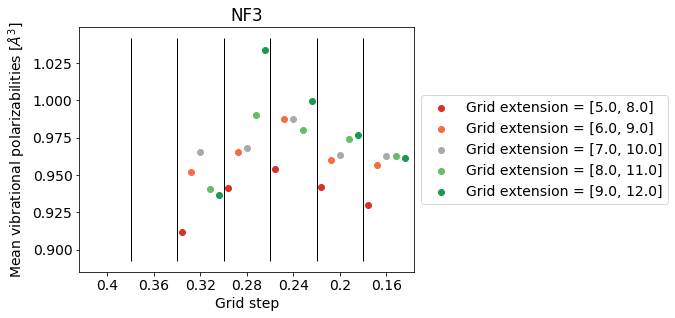

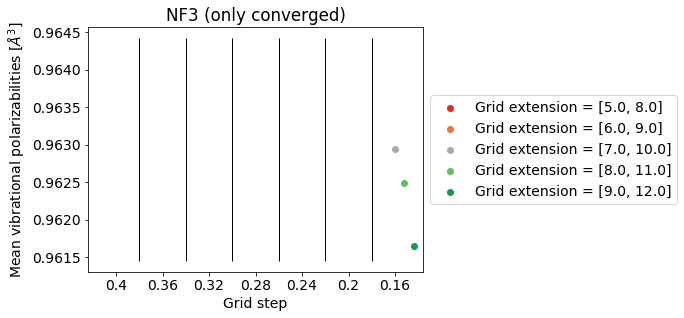

NF3 mean = 0.9623630 A^3; std. dev. = 5.32e-04 A^3; std. dev / mean = 5.530e-04
NF3 mean = 0.9643875 A^3; std. dev. = 2.60e-02 A^3; std. dev / mean = 2.699e-02


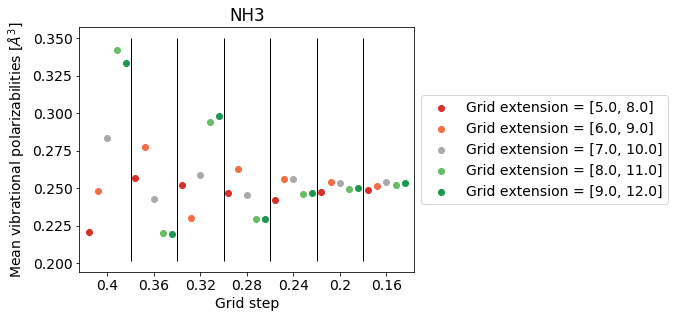

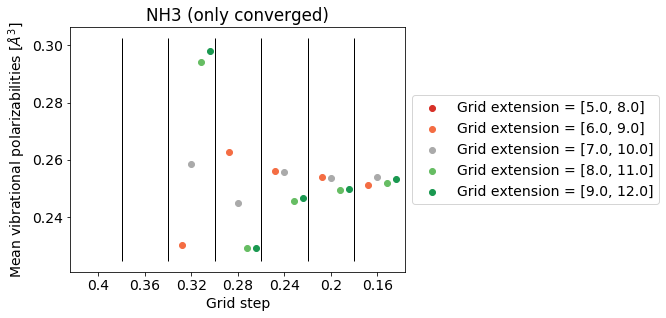

NH3 mean = 0.2535236 A^3; std. dev. = 1.68e-02 A^3; std. dev / mean = 6.638e-02
NH3 mean = 0.2587383 A^3; std. dev. = 3.57e-02 A^3; std. dev / mean = 1.380e-01


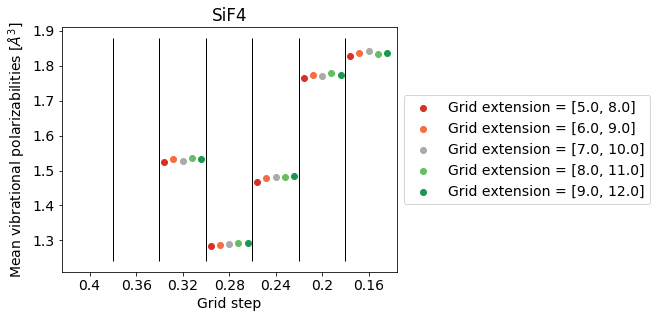

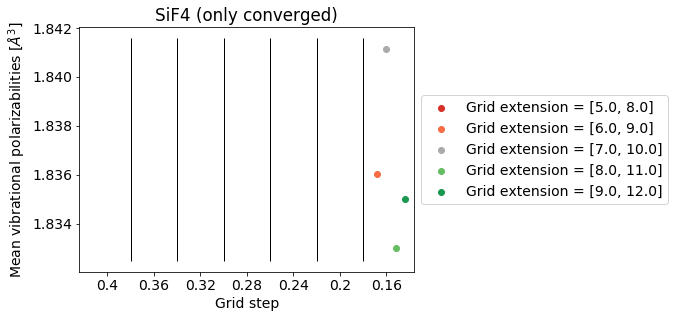

SiF4 mean = 1.8362974 A^3; std. dev. = 3.00e-03 A^3; std. dev / mean = 1.632e-03
SiF4 mean = 1.5324449 A^3; std. dev. = 1.80e-01 A^3; std. dev / mean = 1.177e-01


In [8]:
for name in MOLECULES:
    plot_mean_vib_pols(name)
    plot_mean_vib_pols(name, only_converged=True)
    mean_vib_pols_stats(name, only_converged=True)
    mean_vib_pols_stats(name, only_not_converged=True)

## Precision on the mean vibrational polarizability

The output of the above cell shows that statistics such as the mean value and the standard deviation of each mean vibrational polarizability can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged mean vibrational polarizabilities. Let us see how all these values can be used to assess the expected precision on the mean vibrational polarizability. This precision should be linked to the precision per atom on the total energy is around 1 meV (or ~ 8 cm$^{-1}$): increasing or decreasing that value should have a similar effect on the errors on the mean vibrational polarizability energy (but that won't be studied).

In order to do that, we need to gather the mean mean vibrational polarizability and the standard deviation for each mean vibrational polarizability. This is done in the following cell, discriminating the data coming from converged and not converged calculations.

In [9]:
# The stats obtained along with the above plots are stored in the
# following dictionary, which has the molcule names as key. Stats for
# both converged and non-converged stats are computed, except for some
# cases defined above (where the non-converged results cannot be computed).
stats = {}
# Loop over the molecules
for name in MOLECULES:
    stats[name] = {"converged": None, "not_converged": None}
    # Find the converged mean mean vibrational polarizability and standard deviation
    mean_c, std_dev_c = mean_vib_pols_stats(
        name, only_converged=True, verbosity=False
    )
    stats[name]["converged"] = {"mean": mean_c, "std_dev": std_dev_c}
    # Find the non-converged mean energy and standard deviation
    mean_nc, std_dev_nc = mean_vib_pols_stats(
        name, only_not_converged=True, verbosity=False
    )
    stats[name]["not_converged"] = {"mean": mean_nc, "std_dev": std_dev_nc}
    # It is expected for the converged standard deviation to be larger
    # than the non-converged one
    if std_dev_nc and std_dev_nc < std_dev_c:
        print(
            f"The mean vibrational polarizability of molecule {name} "
            f"has a larger standard deviation for converged calculations "
            f"({std_dev_c:.2e} > {std_dev_nc:.2e})"
        )

The mean vibrational polarizability of molecule CH4 has a larger standard deviation for converged calculations (2.02e-04 > 1.14e-04)
The mean vibrational polarizability of molecule N2 has a larger standard deviation for converged calculations (3.33e-08 > 1.26e-08)


Three mean vibrational polarizabilities have a larger standard deviation for converged calculations than for not converged ones.

We can count the number of supposedly converged mean vibrational polarizabilities below a given limit in order to state which is the expected precision on the mean vibrational polarizability (within 3 sigma). This is rather similar to the study performed for the phonon energies.

In [10]:
def nb_under_3_std_dev(precision, only_converged=True,
                       only_not_converged=False):
    """
    Parameters
    ----------
    precision : float
        Precision on the mean vibrational polarizabilities
        (in A^3).
    
    Returns
    -------
    int
        The number of mean vibrational polarizabilities
        (supposed to be converged) in the test set for which
        three times the standard deviation is below the given
        precision.
    """
    # Set the key
    if only_converged:
        key = "converged"
    if only_not_converged:
        key = "not_converged"
    # Gather the standard deviations
    std_devs = [value[key]["std_dev"] for value in stats.values()]
    # Return the number of phonon energies with a standard deviation
    # below the specified precision
    return sum(3*std_dev <= precision for std_dev in std_devs)

It is now possible to study how many mean vibrational polarizabilities are such that 3 standard deviations are below a given precision as a function of the precision. This will allow us to evaluate the precision on the mean vibrational polarizability. This is done by finding the maximum difference between the converged and non-converged results for a given precision.

Precision: 8.99e-03 A^3
Precision: 7.75e-02 A^3


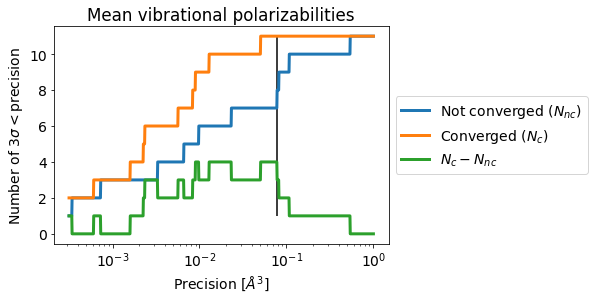

In [11]:
# Define a wide range of precisions
exponents = np.linspace(-3.5, 0, 1000)
precisions = [10**(n) for n in exponents]
# Get the number of converged and non-converged mean vibrational polarizabilities below that
# precision
nb_c = [nb_under_3_std_dev(precision) for precision in precisions]
nb_nc = [
    nb_under_3_std_dev(precision, only_not_converged=True)
    for precision in precisions
]
# Compute the difference between both arrays
diff = np.array(nb_c)-np.array(nb_nc)
# Find the precision, associated with the largest difference
argmax = np.argmax(diff)
precision = precisions[argmax]
print(f"Precision: {precision:.2e} A^3")
argmax = np.argmax(diff[::-1])
precision = precisions[::-1][argmax]
print(f"Precision: {precision:.2e} A^3")
# Plot all the relevant data as a function of the precision
plt.plot(precisions, nb_nc, label=r"Not converged ($N_{nc}$)", lw=3)
plt.plot(precisions, nb_c, label=r"Converged ($N_{c}$)", lw=3)
plt.plot(precisions, diff, label=r"$N_c - N_{nc}$", lw=3)
plt.xscale('log')
plt.title("Mean vibrational polarizabilities")
plt.xlabel(r"Precision [$\AA^3$]")
plt.ylabel(r"Number of $3 \sigma < $precision")
plt.vlines(precision, min(nb_nc), max(nb_c))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

There is not really a peak for the difference between the number of converged and not converged mean vibrational polarizabilities under a given precision. If there is to be one, it is rather a large, flat area between 8.99 10$^-3$ and 7.45 10$^-2$ A$^3$. The precision on the mean vibrational polarizability is therefore more difficult to define than for the mean electronic polarizability. This is expected, as the former is a more involved computation, based on both dipoles and phonon energies calculations, while the latter is only based on dipole calculations.

## Plot the dispersion

The above cell shows that statistics such as the mean value and the standard deviation of each mean vibrational polarizability energy can be conveniently accessed. Most importantly, one can easily discriminate converged and non-converged mean vibrational polarizabilities. Let us see how all these values can be used to do some plots, spanning the whole test set.

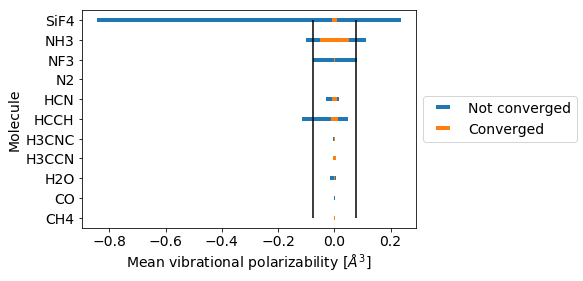

In [12]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    x_err = []  # Width of each error bar
    # Loop over the molecules
    for value in stats.values():
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            converged_mean = value["converged"]["mean"]
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Set the y-axis as an ID of the mean vibrational polarizability
    y = np.arange(len(x_err))
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.yticks(y, [name for name in stats])
plt.xlabel("Mean vibrational polarizability [$\AA^3$]")
plt.ylabel("Molecule")
plt.vlines([-precision, precision], min(y), max(y))
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.show()

This is the same plot as above, except that the y-axis gives the mean mean vibrational polarizability for the converged calculations. It seems that large mean vibrational polarizabilities tend to give larger errors than the smaller ones.

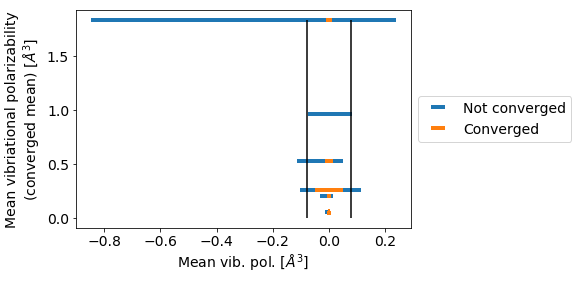

In [13]:
# Loop over the converged and not-converged data to plot the errorbars
for key in ["not_converged", "converged"]:
    x = []  # Center of each error-bar
    y = []  # Mean mean vibrational polarizability of the converged calculations
    x_err = []  # Width of each error-bars along the x-axis
    # Loop over the molecules
    for value in stats.values():
        # Define the location on the y-axis
        converged_mean = value["converged"]["mean"]
        y.append(converged_mean)
        # Define the width of the error-bar
        if not isinstance(value[key]["std_dev"], np.float64):
            x_err.append(0)
        else:    
            x_err.append(3*value[key]["std_dev"])
        # Define the center of the error-bar for non-converged results
        if key == "not_converged":
            not_converged_mean = value["not_converged"]["mean"]
            if (not isinstance(converged_mean, np.float64) 
                    or not isinstance(not_converged_mean, np.float64)):
                x.append(0)
            else:
                x.append(not_converged_mean - converged_mean)
    # Set the center of the error-bars for converged results as 0
    if key == "converged":
        x = np.zeros_like(x_err)
    # Plot the error-bars
    label = key.replace("_", " ").capitalize()
    plt.errorbar(x, y, xerr=x_err, linestyle="", elinewidth=4, label=label)
# Finalize the plot
plt.xlabel("Mean vib. pol. [$\AA^3$]")
plt.ylabel("Mean vibriational polarizability\n(converged mean) [$\AA^3$]")
plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
plt.vlines([-precision, precision], min(y), max(y))
plt.show()